# More Prophet

*Anders Poirel 26-03-2020*

Goals: make the simplest prophet model, with lower allowed complexity of seasonal components, and no added regressors. Compare to baseline

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [3]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

In [4]:
sns.set()

In [5]:
help(Prophet)

Help on class Prophet in module fbprophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear' or 'logistic' to specify a linear or logistic
 |      trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selected uniforml

## Pre-processing 

Same as before

In [6]:
def data_preprocessing(path):
    features = pd.read_csv(path)
    features = features.drop(['year', 'weekofyear'],
                            axis = 1)
    features = features.drop(['reanalysis_sat_precip_amt_mm',
                              'reanalysis_tdtr_k'],
                            axis = 1)
    features = features.rename({'week_start_date': 'ds'}, axis = 1)
    features_sj = features[features['city'] == 'sj'].drop('city', axis = 1)
    features_iq = features[features['city'] == 'iq'].drop('city', axis = 1)
    return (features_sj, features_iq)

In [7]:
DATA_PATH = '../data/raw'
train_sj, train_iq = data_preprocessing(join(DATA_PATH,
    'dengue_features_train.csv'))
test_sj, test_iq = data_preprocessing(join(DATA_PATH,
    'dengue_features_test.csv'))

In [8]:
train_labels = pd.read_csv(join(DATA_PATH, 'dengue_labels_train.csv'))

## Simple model

### San Juan

In [9]:
to_drop = list(train_sj.columns[1:])
train_sj = train_sj.drop(to_drop, axis = 1)
train_sj['y'] = train_labels[train_labels['city'] == 'sj']['total_cases']

In [13]:
model_sj = Prophet(
    growth = 'linear',
    yearly_seasonality = 10,
    weekly_seasonality = False,
    daily_seasonality = False,
    seasonality_mode = 'multiplicative'
)

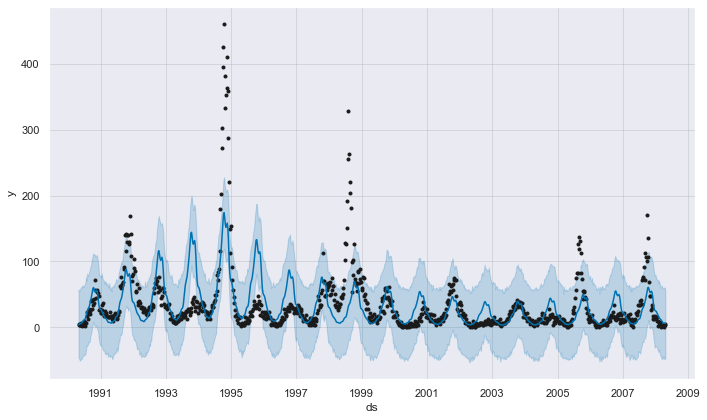

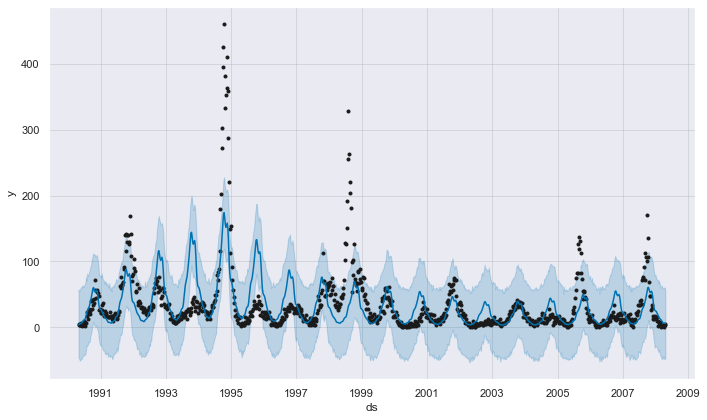

In [14]:
model_sj.fit(train_sj)
forecast_sj = model_sj.predict(train_sj)
model_sj.plot(forecast_sj)

Cross validation

In [12]:
cv_sj = cross_validation(model_sj, horizon = '730 days')
mean_absolute_error(cv_sj['yhat'], cv_sj['y'])

INFO:fbprophet:Making 10 forecasts with cutoffs between 1997-04-25 00:00:00 and 2006-04-23 00:00:00


26.383727615565434

Performs slightly better than previous iteration of prophet

### Iquitos

In [72]:
to_drop = list(train_iq.columns[1:])
train_iq = train_iq.drop(to_drop, axis = 1)
train_iq['y'] = train_labels[train_labels['city'] == 'iq']['total_cases']

In [76]:
model_iq = Prophet(
    growth = 'linear',
    yearly_seasonality = 5,
    weekly_seasonality = False,
    daily_seasonality = False
)

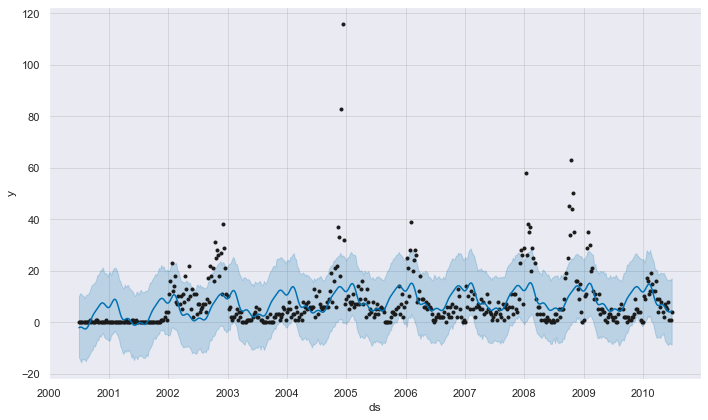

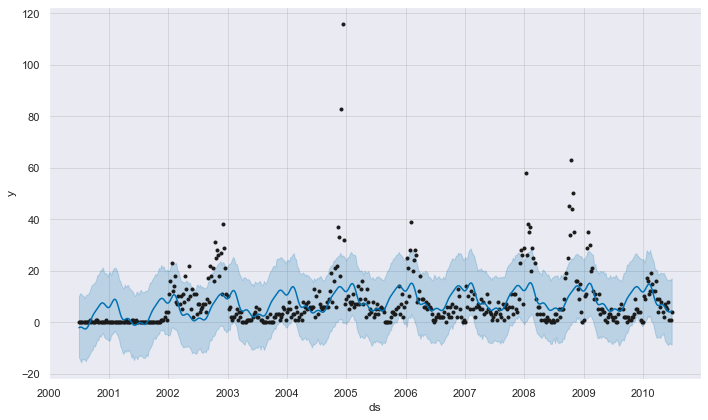

In [77]:
model_iq.fit(train_iq)
forecast_iq = model_iq.predict(train_iq)
model_iq.plot(forecast_iq)

Cross validation

In [78]:
cv_iq = cross_validation(model_iq, horizon = '730 days')
mean_absolute_error(cv_iq['yhat'], cv_iq['y'])

INFO:fbprophet:Making 2 forecasts with cutoffs between 2007-06-26 00:00:00 and 2008-06-25 00:00:00


7.90225934397715

Iquitos performs worse on this simple model

NOTE: Setting `seasonality_mode` to additive significantly improved the score. We're down to 26 MAE for San Jose